In [827]:
import psycopg2
import random
import names
import uuid
import datetime
import re
import matplotlib.pyplot as plt

In [828]:
#część odpowiedzialna za łączenie się z bazą, wywoływanie zapytań, obsługiwanie błędów, zwracanie napotkanych wartości
def index_tester(what_index, Query, Drop):
    try:
        con = psycopg2.connect(
                host = "127.0.0.11",
                database="ZSBD_p1",
                user = "inzdanych123",
                password = "inzdanych123")
        cur = con.cursor()

        cur.execute(Drop)

        if what_index != None:
            cur.execute(what_index)

        cur.execute(Query)
        query_output = cur.fetchall()
        
        if query_output != None:
            return query_output

    except (Exception, psycopg2.Error) as error:
        return error
    
    finally:
        if con:
            cur.close()
            con.close()

In [829]:
def index_tester_all(Q, D, index_query):
    index_list = [None, 'btree', 'HASH', 'gist', 'spgist', 'gin', 'BRIN']

    seq_scan_dict_floats_planning = {}
    seq_scan_dict_floats_executing = {}
    planning_time = []
    execution_time = []
    planning_time_non_seq = []
    execution_time_non_seq = []

    for index in index_list:
        #testowanie poszczególnych rodzajów indeksów 
        if index == None:
            mes = index_tester(None, Q, D)
        else:
            mes = index_tester(index_query %(index), Q, D)

        if type(mes) == list:
            #odczytywanie wartości z EXPLAIN ANALYZE
            if str(mes[0]).split('on')[0] == "('Seq Scan ":
                #zapis dla wartości (czasów), dla których w zapytaniu NIE został wykorzystany konkretny indeks  
                planning_time.append(float(re.findall(r'[\d]*[.][\d]+', str(mes[-2:][0]))[0]))
                execution_time.append(float(re.findall(r'[\d]*[.][\d]+', str(mes[-2:][1]))[0]))

                seq_scan_dict_floats_planning['seq scan'] = planning_time
                seq_scan_dict_floats_executing['seq scan'] = execution_time 
            else:
                #zapis dla wartości (czasów), dla których w zapytaniu został wykorzystany konkretny indeks  
                planning_time_non_seq.append(float(re.findall(r'[\d]*[.][\d]+', str(mes[-2:][0]))[0]))
                execution_time_non_seq.append(float(re.findall(r'[\d]*[.][\d]+', str(mes[-2:][1]))[0]))

                seq_scan_dict_floats_planning[index] = planning_time_non_seq[0]
                seq_scan_dict_floats_executing[index] = execution_time_non_seq[0]
        else:
            print(index, ' zwrocil blad:', '\n', mes)
    
    if len(seq_scan_dict_floats_executing) == 1:
        print("DO TEGO POLECENIA TESTOWANE INDEKS-y, NIE ZMIENIAJĄ SPOSOBU WYSZUKIWANIA \n POZOSTAJE SEQ SCAN \n \n JEŻELI WYSTĘPUJĄ PATRZ NA BŁĘDY")
    else:
        #wizualizacja zapisanych wcześniej wartości
        print("DODATKOWO, JEŻELI WYSTĘPUJĄ - PATRZ NA BŁĘDY")
        try:
            seq_scan_dict_floats_executing['seq scan'] = seq_scan_dict_floats_executing['seq scan'][0]
            seq_scan_dict_floats_planning['seq scan'] = seq_scan_dict_floats_planning['seq scan'][0]
            seq_scan_dict_floats_executing['no index'] = seq_scan_dict_floats_executing.pop('seq scan')
            seq_scan_dict_floats_planning['no index'] = seq_scan_dict_floats_planning.pop('seq scan')
        except(TypeError):
            pass

        fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100)
        
        names = list(seq_scan_dict_floats_planning.keys())
        values = list(seq_scan_dict_floats_planning.values())
        ax1.bar(range(len(seq_scan_dict_floats_planning)), values, tick_label=names)
        ax1.set_ylabel('t [ms]')
        ax1.set_title('planning time')

        names = list(seq_scan_dict_floats_executing.keys())
        values = list(seq_scan_dict_floats_executing.values())
        ax2.bar(range(len(seq_scan_dict_floats_executing)), values, tick_label=names)
        ax2.set_ylabel('t [ms]')
        ax2.set_title('executing time')
        plt.show()

In [830]:
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med.objawy WHERE bol_glowy is TRUE;'
D = 'DROP INDEX IF EXISTS ai_med.data_bol;'
index_query = 'CREATE INDEX data_bol on ai_med.objawy using %s (bol_glowy);'

In [831]:
index_tester_all(Q, D, index_query)

gist  zwrocil blad: 
 data type boolean has no default operator class for access method "gist"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

spgist  zwrocil blad: 
 data type boolean has no default operator class for access method "spgist"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

gin  zwrocil blad: 
 data type boolean has no default operator class for access method "gin"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

BRIN  zwrocil blad: 
 data type boolean has no default operator class for access method "brin"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

DO TEGO POLECENIA TESTOWANE INDEKS-y, NIE ZMIENIAJĄ SPOSOBU WYSZUKIWANIA 
 POZOSTAJE SEQ SCAN 
 
 JEŻELI WYSTĘPUJĄ PATRZ NA BŁĘDY


In [832]:
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med.objawy WHERE bol_glowy = TRUE;'
D = 'DROP INDEX IF EXISTS ai_med.data_bol;'
index_query = 'CREATE INDEX data_bol on ai_med.objawy using %s (bol_glowy);'

In [833]:
index_tester_all(Q, D, index_query)

gist  zwrocil blad: 
 data type boolean has no default operator class for access method "gist"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

spgist  zwrocil blad: 
 data type boolean has no default operator class for access method "spgist"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

gin  zwrocil blad: 
 data type boolean has no default operator class for access method "gin"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

BRIN  zwrocil blad: 
 data type boolean has no default operator class for access method "brin"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

DO TEGO POLECENIA TESTOWANE INDEKS-y, NIE ZMIENIAJĄ SPOSOBU WYSZUKIWANIA 
 POZOSTAJE SEQ SCAN 
 
 JEŻELI WYSTĘPUJĄ PATRZ NA BŁĘDY


In [834]:
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med."leczenie_w_kierunku_kod_ICD_10"' + " WHERE data_zakonczenia_leczenia_i10 >= '2021-02-01' "
Q+= "AND data_zakonczenia_leczenia_i10 <= '2021-02-28';"
index_name_query = 'data_icd_10'

D = 'DROP INDEX IF EXISTS ai_med.%s;' %(index_name_query)
index_query = 'CREATE INDEX '
index_query += index_name_query
index_query += ' on ai_med."leczenie_w_kierunku_kod_ICD_10" using %s (data_zakonczenia_leczenia_i10);' 

gist  zwrocil blad: 
 data type date has no default operator class for access method "gist"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

spgist  zwrocil blad: 
 data type date has no default operator class for access method "spgist"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

gin  zwrocil blad: 
 data type date has no default operator class for access method "gin"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

DODATKOWO, JEŻELI WYSTĘPUJĄ - PATRZ NA BŁĘDY


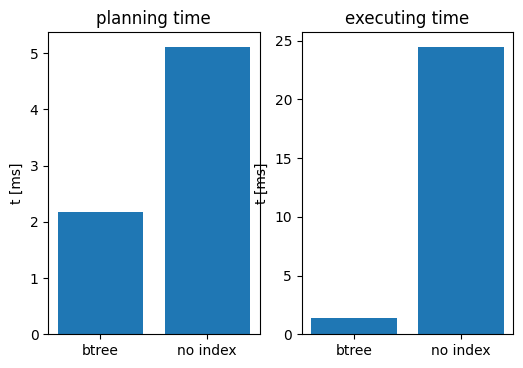

In [835]:
index_tester_all(Q, D, index_query)

In [836]:
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med.morfologia' + " WHERE mcv >= 20.0 AND mcv <= 30.0;"
index_name_query = 'mcv_test'

D = 'DROP INDEX IF EXISTS ai_med.%s;' %(index_name_query)
index_query = 'CREATE INDEX '
index_query += index_name_query
index_query += ' on ai_med.morfologia using %s (mcv);' 

gist  zwrocil blad: 
 data type real has no default operator class for access method "gist"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

spgist  zwrocil blad: 
 data type real has no default operator class for access method "spgist"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

gin  zwrocil blad: 
 data type real has no default operator class for access method "gin"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

DODATKOWO, JEŻELI WYSTĘPUJĄ - PATRZ NA BŁĘDY


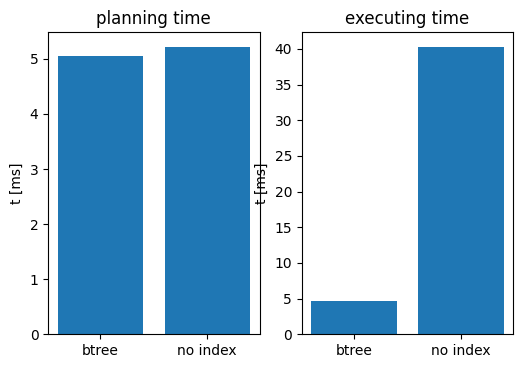

In [837]:
index_tester_all(Q, D, index_query)

In [845]:
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med.morfologia' + " WHERE mcv >= 55.0;"
index_name_query = 'mcv_test'

D = 'DROP INDEX IF EXISTS ai_med.%s;' %(index_name_query)
index_query = 'CREATE INDEX '
index_query += index_name_query
index_query += ' on ai_med.morfologia using %s (mcv);' 

In [846]:
index_query

'CREATE INDEX mcv_test on ai_med.morfologia using %s (mcv);'

gist  zwrocil blad: 
 data type real has no default operator class for access method "gist"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

spgist  zwrocil blad: 
 data type real has no default operator class for access method "spgist"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

gin  zwrocil blad: 
 data type real has no default operator class for access method "gin"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

DODATKOWO, JEŻELI WYSTĘPUJĄ - PATRZ NA BŁĘDY


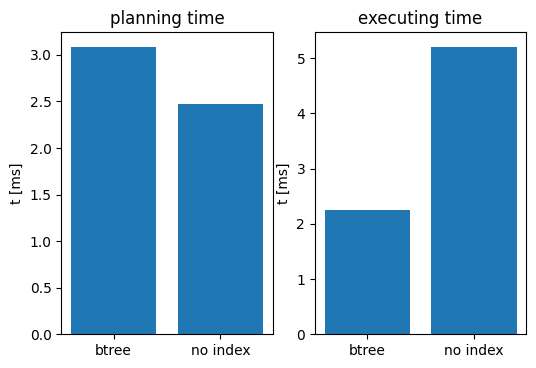

In [839]:
index_tester_all(Q, D, index_query)

In [853]:
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med."Nazwa pliku z notatkami lekarskimi"' +  " WHERE lekarz_rodzinny LIKE ('%e1920%');"
index_name_query = 'notatki_plik_test'

D = 'DROP INDEX IF EXISTS ai_med.%s;' %(index_name_query)
index_query = 'CREATE INDEX '
index_query += index_name_query
index_query += ' on ai_med."Nazwa pliku z notatkami lekarskimi" using %s (lekarz_rodzinny);' 

In [854]:
index_query

'CREATE INDEX notatki_plik_test on ai_med."Nazwa pliku z notatkami lekarskimi" using %s (lekarz_rodzinny);'

In [855]:
index_tester_all(Q, D, index_query)

gist  zwrocil blad: 
 data type character varying has no default operator class for access method "gist"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

gin  zwrocil blad: 
 data type character varying has no default operator class for access method "gin"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

DO TEGO POLECENIA TESTOWANE INDEKS-y, NIE ZMIENIAJĄ SPOSOBU WYSZUKIWANIA 
 POZOSTAJE SEQ SCAN 
 
 JEŻELI WYSTĘPUJĄ PATRZ NA BŁĘDY
